# Import Dependencies

In [41]:
import numpy as np
import pandas as pd
import gzip
import json

import os
import gzip
import json

from pprint import pprint


import os
import pandas as pd

# Turkish StopWords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\itsmm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Influencer Category Classification



1.   Read Data
2.   Preprocess Data
3.   Prepare Model
4.   Predict Test Data
4.   Save outputs



In [42]:
# Step 1: Define File Paths Dynamically
import os
import pandas as pd

# Get the current notebook directory
current_notebook_dir = os.getcwd()

# Get the repo directory (assuming notebooks are inside the "notebooks" folder)
repo_dir = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Get the data directory
data_dir = os.path.join(repo_dir, 'data')

# Get the training directory
training_dir = os.path.join(data_dir, 'training')

# File path for 'train-classification.csv'
train_classification_path = os.path.join(training_dir, 'train-classification.csv')

# Step 2: Validate File Path
if not os.path.exists(train_classification_path):
    raise FileNotFoundError(f"File not found: {train_classification_path}")

# Step 3: Load Data Dynamically
train_classification_df = pd.read_csv(train_classification_path)

# Step 4: Rename Columns
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Step 5: Unify Labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)

# Step 6: Create User-to-Category Mapping
username_to_category = train_classification_df.set_index("user_id").to_dict()["category"]

# Step 7: Check Category Distribution
print("Category Distribution:")
print(train_classification_df['category'].value_counts(), "\n")

# Step 8: Generate Categorical Mapping (Optional for Numeric Conversion)
category_mapping = {category: idx for idx, category in enumerate(train_classification_df['category'].unique())}
print("Category Mapping:")
print(category_mapping, "\n")

# Step 9: Verify Output
print("First few rows of the training classification DataFrame:")
print(train_classification_df.head())

Category Distribution:
category
food                    511
health and lifestyle    503
tech                    346
entertainment           323
fashion                 299
travel                  294
art                     191
mom and children        149
sports                  113
gaming                   13
Name: count, dtype: int64 

Category Mapping:
{'mom and children': 0, 'food': 1, 'travel': 2, 'gaming': 3, 'fashion': 4, 'health and lifestyle': 5, 'tech': 6, 'entertainment': 7, 'sports': 8, 'art': 9} 

First few rows of the training classification DataFrame:
           user_id          category
0    taskirancemal  mom and children
1    tam_kararinda              food
2         spart4nn              food
3  sosyalyiyiciler              food
4  sonaydizdarahad  mom and children


In [43]:
print(username_to_category["kod8net"] + "\n")

# stats about the labels
train_classification_df.groupby("category").count()

tech



,user_id
category,
art,191
entertainment,323
fashion,299
food,511
gaming,13
health and lifestyle,503
mom and children,149
sports,113
tech,346


Category for user 'kod8net': tech

Detailed Category Stats:
                      count  percentage
category                               
art                     191    6.965718
entertainment           323   11.779723
fashion                 299   10.904449
food                    511   18.636032
gaming                   13    0.474106
health and lifestyle    503   18.344274
mom and children        149    5.433990
sports                  113    4.121080
tech                    346   12.618527
travel                  294   10.722101


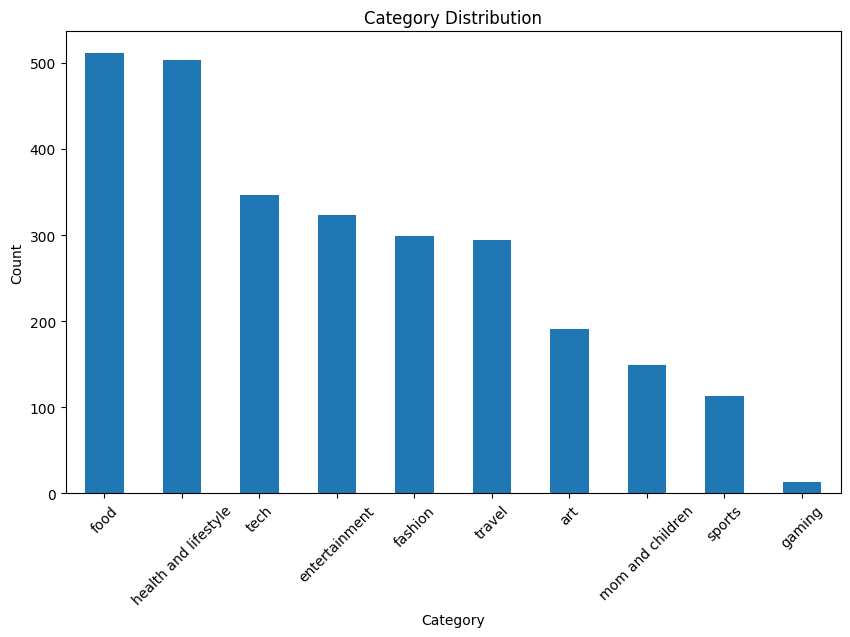

In [44]:
import matplotlib.pyplot as plt

# Validate the mapping works
print(f"Category for user 'kod8net': {username_to_category['kod8net']}")

# Stats about the labels
category_stats = train_classification_df.groupby("category").count().rename(columns={'user_id': 'count'})
category_stats['percentage'] = (category_stats['count'] / category_stats['count'].sum()) * 100

# Display Category Stats
print("\nDetailed Category Stats:")
print(category_stats)

# Visualize Category Distribution
plt.figure(figsize=(10, 6))
category_stats['count'].sort_values(ascending=False).plot(kind='bar')
plt.title('Category Distribution')
plt.ylabel('Count')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.show()

In [45]:
# Step 1: Define File Paths Dynamically
# Get the current notebook directory
current_notebook_dir = os.getcwd()

# Get the repo directory (assuming notebooks are inside the "notebooks" folder)
repo_dir = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Get the data directory
data_dir = os.path.join(repo_dir, 'data')

# Get the training directory
training_dir = os.path.join(data_dir, 'training')

# File path for 'training-dataset.jsonl.gz'
train_data_path = os.path.join(training_dir, 'training-dataset.jsonl.gz')

# Step 2: Initialize Dictionaries for Data
username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()

# Process Data from 'training-dataset.jsonl.gz'
skipped_entries = 0  # Counter for skipped entries

with gzip.open(train_data_path, "rt", encoding="utf-8") as fh:
    for line in fh:
        try:
            sample = json.loads(line)
            profile = sample["profile"]
            username = profile.get("username", "").strip()
            
            if not username:
                skipped_entries += 1
                continue  # Skip if username is missing or empty

            if username in username_to_category:
                # Train data info
                username2posts_train[username] = sample["posts"]
                username2profile_train[username] = profile
            else:
                # Test data info
                username2posts_test[username] = sample["posts"]
                username2profile_test[username] = profile

        except json.JSONDecodeError:
            print(f"Malformed line skipped.")
            skipped_entries += 1

# Stats on Data
train_users = len(username2posts_train)
test_users = len(username2posts_test)
total_users = train_users + test_users

print(f"Number of Training Users: {train_users}")
print(f"Number of Testing Users: {test_users}")
print(f"Total Users Processed: {total_users}")
print(f"Skipped Entries: {skipped_entries}")
print(f"Training Data Proportion: {train_users / total_users:.2%}")

Number of Training Users: 2741
Number of Testing Users: 2674
Total Users Processed: 5415
Skipped Entries: 0
Training Data Proportion: 50.62%


In [46]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

print(train_profile_df.head(2))

     username          id    full_name  \
0  deparmedya  3170700063  Depar Medya   
1  kafesfirin   266439571  KAFES FIRIN   

                                           biography   category_name  \
0           #mediaplanning #mediabuying #sosyalmedya  Local business   
1  📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...           Brand   

  post_count follower_count following_count is_business_account is_private  \
0       None           1167             192                True      False   
1       None          11997              17                True      False   

   ... business_category_name overall_category_name category_enum  \
0  ...                   None                  None         LOCAL   
1  ...                   None                  None         BRAND   

  is_verified_by_mv4b is_regulated_c18  \
0               False            False   
1               False            False   

                                     profile_pic_url should_show_category  \
0  https:

In [47]:
# Test Profie Dataframe
print(test_profile_df.head(2))

                     username          id                    full_name  \
0              beyazyakaliyiz  8634457436           Selam Beyaz Yakalı   
1  totalenergies_istasyonlari  7066643793  TotalEnergies İstasyonları   

                                           biography   category_name  \
0        Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀   Personal blog   
1  TotalEnergies İstasyonları resmi Instagram hes...  Energy Company   

  post_count follower_count following_count is_business_account is_private  \
0       None           1265             665                True      False   
1       None          28025               4                True      False   

   ... business_category_name overall_category_name   category_enum  \
0  ...                   None                  None   PERSONAL_BLOG   
1  ...                   None                  None  ENERGY_COMPANY   

  is_verified_by_mv4b is_regulated_c18  \
0               False            False   
1               False      

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Updated preprocessing function
def preprocess_text(text: str):
    # Lowercasing Turkish Text (preserve emojis, hashtags, and mentions)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Retain emojis, hashtags (#), and mentions (@) while removing other special characters
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers (optional; keeping it based on context may help, decide based on experiments)
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Create a custom stopword list by extending Turkish stopwords
custom_stopwords = turkish_stopwords + [
    "like", "follow", "click", "bio", "share", "post", "insta", "instagram"
]

# Aggregating training data
corpus = []
train_usernames = []

for username, posts in username2posts_train.items():
    train_usernames.append(username)

    # Aggregate posts per user
    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)

        if post_caption != "":
            cleaned_captions.append(post_caption)

    # Join the posts of each user with a newline character
    user_post_captions = "\n".join(cleaned_captions)
    corpus.append(user_post_captions)

# TF-IDF Vectorizer with updated parameters
vectorizer = TfidfVectorizer(
    stop_words=custom_stopwords,
    max_features=5000,  # Increased vocabulary size
    min_df=2,           # Ignore very rare terms
    max_df=0.85         # Ignore very common terms
)

# Fit the vectorizer
vectorizer.fit(corpus)

# Transform training data into vectors
x_post_train = vectorizer.transform(corpus)
y_train = [username_to_category.get(uname, "NA") for uname in train_usernames]

# Aggregating test data
test_usernames = []
test_corpus = []

for username, posts in username2posts_test.items():
    test_usernames.append(username)

    # Aggregate posts per user
    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)

        if post_caption != "":
            cleaned_captions.append(post_caption)

    user_post_captions = "\n".join(cleaned_captions)
    test_corpus.append(user_post_captions)

# Transform test data into vectors (no fitting)
x_post_test = vectorizer.transform(test_corpus)

# Save the vectorizer for future use
import pickle
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print(f"TF-IDF vectorization complete!")
print(f"Training data shape: {x_post_train.shape}")
print(f"Test data shape: {x_post_test.shape}")

TF-IDF vectorization complete!
Training data shape: (2741, 5000)
Test data shape: (2674, 5000)


In [49]:
# Validate that all training data has a valid category
assert y_train.count("NA") == 0, "Some usernames in the training set do not have a valid category label!"

In [50]:
# Extract feature names
feature_names = vectorizer.get_feature_names_out()

# Display feature statistics
print(f"Number of features extracted: {len(feature_names)}")
print("First 10 features:", feature_names[:10])
print("Last 10 features:", feature_names[-10:])

Number of features extracted: 5000
First 10 features: ['abdullah' 'abone' 'about' 'acele' 'acil' 'activities' 'acı' 'ad' 'ada'
 'adam']
Last 10 features: ['şubemiz' 'şubesi' 'şölen' 'şöleni' 'şöyle' 'şükranla' 'şükür' 'şık'
 'şıklık' 'şıklığı']


In [51]:
# Convert TF-IDF vectors to DataFrame
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)

# Display first 2 rows and shape
print(f"TF-IDF DataFrame shape: {df_tfidf.shape}")
print("First two rows of TF-IDF DataFrame:")
print(df_tfidf.head(2))

# Summary statistics for non-zero values
non_zero_stats = (df_tfidf > 0).sum(axis=0).describe()
print("\nNon-zero value statistics for features:")
print(non_zero_stats)

TF-IDF DataFrame shape: (2741, 5000)
First two rows of TF-IDF DataFrame:
   abdullah  abone  about  acele  acil  activities  acı   ad  ada  adam  ...  \
0       0.0    0.0    0.0    0.0   0.0         0.0  0.0  0.0  0.0   0.0  ...   
1       0.0    0.0    0.0    0.0   0.0         0.0  0.0  0.0  0.0   0.0  ...   

   şubemiz  şubesi  şölen  şöleni  şöyle  şükranla  şükür       şık  şıklık  \
0      0.0     0.0    0.0     0.0    0.0       0.0    0.0  0.051486     0.0   
1      0.0     0.0    0.0     0.0    0.0       0.0    0.0  0.000000     0.0   

   şıklığı  
0      0.0  
1      0.0  

[2 rows x 5000 columns]

Non-zero value statistics for features:
count    5000.000000
mean      121.237400
std       148.382254
min         2.000000
25%        48.000000
50%        76.000000
75%       134.000000
max      1839.000000
dtype: float64


In [52]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(df_tfidf, y_train, test_size=0.2, stratify=y_train)

x_train.shape
x_val.shape

(549, 5000)

# Naive Base Classifier

### Now we can pass the numerical values to a classifier, Let's try Naive Base!


In [53]:
from collections import Counter

print("Training Set Class Distribution:")
print(Counter(y_train))

print("Validation Set Class Distribution:")
print(Counter(y_val))

Training Set Class Distribution:
Counter({'food': 409, 'health and lifestyle': 402, 'tech': 277, 'entertainment': 258, 'fashion': 239, 'travel': 235, 'art': 153, 'mom and children': 119, 'sports': 90, 'gaming': 10})
Validation Set Class Distribution:
Counter({'food': 102, 'health and lifestyle': 100, 'tech': 69, 'entertainment': 65, 'fashion': 60, 'travel': 59, 'art': 38, 'mom and children': 30, 'sports': 23, 'gaming': 3})


In [54]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

print(f"Classes: {label_encoder.classes_}")

Classes: ['art' 'entertainment' 'fashion' 'food' 'gaming' 'health and lifestyle'
 'mom and children' 'sports' 'tech' 'travel']


In [55]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

In [56]:
# Train Data
y_train_pred = model.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, zero_division=0))

Accuracy: 0.6733576642335767

Classification Report:
                      precision    recall  f1-score   support

                 art       1.00      0.12      0.22       153
       entertainment       0.63      0.57      0.60       258
             fashion       0.76      0.77      0.77       239
                food       0.80      0.90      0.85       409
              gaming       0.00      0.00      0.00        10
health and lifestyle       0.51      0.84      0.64       402
    mom and children       0.93      0.11      0.20       119
              sports       1.00      0.10      0.18        90
                tech       0.77      0.84      0.80       277
              travel       0.64      0.68      0.66       235

            accuracy                           0.67      2192
           macro avg       0.70      0.50      0.49      2192
        weighted avg       0.73      0.67      0.64      2192



In [57]:
# Validation Data
y_val_pred = model.predict(x_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, zero_division=0))

Accuracy: 0.6029143897996357

Classification Report:
                      precision    recall  f1-score   support

                 art       0.00      0.00      0.00        38
       entertainment       0.52      0.40      0.45        65
             fashion       0.59      0.65      0.62        60
                food       0.82      0.82      0.82       102
              gaming       0.00      0.00      0.00         3
health and lifestyle       0.47      0.87      0.61       100
    mom and children       1.00      0.03      0.06        30
              sports       1.00      0.04      0.08        23
                tech       0.72      0.77      0.74        69
              travel       0.60      0.68      0.63        59

            accuracy                           0.60       549
           macro avg       0.57      0.43      0.40       549
        weighted avg       0.61      0.60      0.55       549



In [58]:
# Step 1: Define File Paths Dynamically
# Get the current notebook directory
current_notebook_dir = os.getcwd()

# Get the repo directory (assuming notebooks are inside the "notebooks" folder)
repo_dir = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Get the data directory
data_dir = os.path.join(repo_dir, 'data')

# Get the testing directory
testing_dir = os.path.join(data_dir, 'testing')

# File path for 'test-classification-round1.dat'
test_data_path = os.path.join(testing_dir, 'test-classification-round1.dat')

# Step 2: Preview First 5 Lines of the Test File
with open(test_data_path, "rt", encoding="utf-8") as fh:
    for i, line in enumerate(fh):
        print(line.strip())
        if i == 4:  # Print only the first 5 lines
            break

print("*****")

# Step 3: Extract Usernames from Test Data
test_unames = []
with open(test_data_path, "rt", encoding="utf-8") as fh:
    for line in fh:
        test_unames.append(line.strip())

# Step 4: Verify Output
print(test_unames[:5])  # Display the first 5 usernames

ozhotelstr
elleturkiye
sozerinsaatorhangazi
sanliurfapiazzaavym
rusanozden
*****
['ozhotelstr', 'elleturkiye', 'sozerinsaatorhangazi', 'sanliurfapiazzaavym', 'rusanozden']


In [59]:
x_test = []

for uname in test_unames:
  try:
    index = test_usernames.index(uname)
    x_test.append(x_post_test[index].toarray()[0])
  except Exception as e:
    try:
      index = train_usernames.index(uname)
      x_test.append(x_post_train[index].toarray()[0])
    except Exception as e:
      print(uname)


print(test_unames.remove("screenname"))

df_test = pd.DataFrame(np.array(x_test), columns=feature_names)
df_test.head(2)

screenname
None


,abdullah,abone,about,acele,acil,activities,acı,ad,ada,adam,...,şubemiz,şubesi,şölen,şöleni,şöyle,şükranla,şükür,şık,şıklık,şıklığı
0,0.0,0.0,0.0,0.0,0.0,0.013628,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.026119,0.0,0.0,0.011141,0.0,0.0


In [60]:
test_pred = model.predict(df_test)

output = dict()
for index, uname in enumerate(test_unames):
  output[uname] = test_pred[index]

In [61]:
with open("output.json", "w") as of:
  json.dump(output, of, indent=4)

# Like Count Prediction


Here, we use the average like_count of the user's previous posts to predict each post's like_count

In [62]:
def predict_like_count(username, current_post=None):
  def get_avg_like_count(posts:list):
    total = 0.
    for post in posts:
      if current_post is not None and post["id"] == current_post["id"]:
        continue

      like_count = post.get("like_count", 0)
      if like_count is None:
        like_count = 0
      total += like_count

    if len(posts) == 0:
      return 0.

    return total / len(posts)

  if username in username2posts_train:
    return get_avg_like_count(username2posts_train[username])
  elif username in username2posts_test:
    return get_avg_like_count(username2posts_test[username])
  else:
    print(f"No data available for {username}")
    return -1

In [63]:
def log_mse_like_counts(y_true, y_pred):
  """
  Calculate the Log Mean Squared Error (Log MSE) for like counts (log(like_count + 1)).

  Parameters:
  - y_true: array-like, actual like counts
  - y_pred: array-like, predicted like counts

  Returns:
  - log_mse: float, Log Mean Squared Error
  """
  # Ensure inputs are numpy arrays
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Log transformation: log(like_count + 1)
  log_y_true = np.log1p(y_true)
  log_y_pred = np.log1p(y_pred)

  # Compute squared errors
  squared_errors = (log_y_true - log_y_pred) ** 2

  # Return the mean of squared errors
  return np.mean(squared_errors)

In [64]:
# Train Dataset evaluation

y_like_count_train_true = []
y_like_count_train_pred = []
for uname, posts in username2posts_train.items():
  for post in posts:
    pred_val = predict_like_count(uname, post)
    true_val = post.get("like_count", 0)
    if true_val is None:
      true_val = 0

    y_like_count_train_true.append(true_val)
    y_like_count_train_pred.append(pred_val)

print(f"Log MSE Train= {log_mse_like_counts(y_like_count_train_true, y_like_count_train_pred)}")

Log MSE Train= 1.2271047744059362


In [65]:
# Step 1: Define File Paths Dynamically
# Get the current notebook directory
current_notebook_dir = os.getcwd()

# Get the repo directory (assuming notebooks are inside the "notebooks" folder)
repo_dir = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Get the data directory
data_dir = os.path.join(repo_dir, 'data')

# Get the testing directory
testing_dir = os.path.join(data_dir, 'testing')

# File path for 'test-regression-round1.jsonl'
test_dataset_path = os.path.join(testing_dir, 'test-regression-round1.jsonl')

# File path for output
output_dir = os.path.join(data_dir, 'output')
os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
output_file_path = os.path.join(output_dir, 'test-regression-round1.jsonl')

# Step 2: Process the Test Dataset
to_predict_like_counts_usernames = []
output_list = []

with open(test_dataset_path, "rt", encoding="utf-8") as fh:
    for line in fh:
        sample = json.loads(line)

        # Perform prediction
        pred_val = predict_like_count(sample["username"])  # Ensure `predict_like_count` is defined
        sample["like_count"] = int(pred_val)
        output_list.append(sample)

# Step 3: Save the Output to a File
with open(output_file_path, "wt", encoding="utf-8") as of:
    json.dump(output_list, of)

# Step 4: Output Verification
print(f"Processed data saved to: {output_file_path}")

Processed data saved to: c:\Users\itsmm\OneDrive\Desktop\CS412\CS412-InstagramInfluencersAnalysis\data\output\test-regression-round1.jsonl


In [66]:
# output_list first 3 items
pprint(output_list[:3])

[{'caption': 'KOZA 2023 2.si Damla’nın koleksiyonu, Latincede ‘Memento Mori’ '
             'olarak bilinen ‘ölümlü olduğunu hatırla’ anlamındaki ifadeden '
             'esinleniyor. Koleksiyon, hayatın ve ölümün, para, işçi, kral ve '
             'kraliçe kavramları üzerinden yaratıcı görünümlerle bir araya '
             'getirilmesini amaçlıyor. Ölüm sembollerinden esinlenen desenler '
             'kullanan Damla, “kağıt parçasından ibaret olmak” kavramını '
             'vurguluyor. Koleksiyon, yaşamın ve ölümün aynı anda ifade '
             'edilmesini hedefliyor; kırmızı ve mavi ışıklarla veya '
             'gözlüklerle görülen hologram efekti kullanılarak bu konsept '
             'sahneye taşınıyor. Kırmızı renk ölümü, mavi ise yaşamı '
             'simgeliyor. Koleksiyon, ofis giyimlerinden esinlenerek '
             'kravatlar, gömlekler ve evrak çantaları içeriyor. Klasik sivri '
             'burun çizmelerin üzerine spor ayakkabıların üst yüzeyi '
             'yerle